## Edge handling

Edge handling is a very important aspect of deconvolution.  If edges are not handled properly severe artifacts can occur when deconvolving.  If edges are handled properly these artifacts are minimized, and in fact, as this example shows it may even be possible to reconstruct signal slightly slightly beyond the acquired field of view (though keep in mind this example assumes no noise, so in real conditions it is harder to reconstruct signal outside the boundaries).

This example has been designed to work in a conda environment that has numpy, matplotlib, scipy and skimage, and shouldn't need complicated dependencies.

## Define functions for PSF, forward model and RIchardson Lucy

This example has been designed to work in a conda environment that has numpy, matplotlib and skimage, and doesn't need complicated dependencies.  To make this example relatively independent of the experimental modules, In this block we define functions for

1.  A forward model -> Convolution + Poisson Noise
2.  A paraxial PSF
3.  2D Richardson Lucy (on the CPU) using Numpy
4.  A 2d image plotting helper

The paraxial PSF function and forward model function were inspired by Matlab code by James Maton that can be found [here](https://github.com/jdmanton/rl_positivity_sim)

## Edge handling math background

I had a great conversation with [Andrew York](https://andrewgyork.github.io/) recently about framing Richardson Lucy as a [general tool](https://pubmed.ncbi.nlm.nih.gov/24436314/) that can be used to solve different types of problems by normalizing the RL equation by a factor $H^T ones$ where $H$ is the forward model of the system. 

Below is a justificaton for a simple modification to the Richardson Lucy algorithm which can be used to handle edges.  In this case I let's assume no noise, I let $H^t ones = n$, $o_k$ be the object estimate at iteration $k$, $i$ be the observed image, and $h$ the point spread function.  

$$
    {o}_{k+1} = \frac{{o}_{k}\left[\frac{i}{o_{k}*h}*h^*\right]}{n}
$$

In practice we only image a window $w$ in a larger space

$$
    {o}_{k+1} = \frac{o_{k}\left[\frac{wi}{o_{k}*h}*h^*\right]}{n}
$$

Now let's assume we have estimated the object $o$ perfectly, in that case the term $o_{k}*h$ will be $i$ (remember we are assuming no noise).  And if we have a perfect estimate, we no nonger want to change it, so the update term of the Richardson Lucy equation should be 1 everywhere.

$$
    \frac{\left[\frac{wi}{i}*h^*\right]}{n}=1
$$

Solving the above equation gives us an expression for the normalization factor $n$ for proper edge handling. 

$$
    n=\frac{wi}{i}*h^*=w*h^*
$$



## Define Richardson Lucy with edge normalization

Below we define a modified version of Richardson Lucy which takes in an optional normalization factor and a first guess.  

In [22]:
def richardson_lucy_np(image, psf, num_iters, normal=None, first_guess=None):
    image=image.astype('float64')
    psf=psf.astype('float64')
    
    delta = 0.00001
    otf = rfftn(fftshift(psf))
    otf_ = np.conjugate(otf)    
    
    if (first_guess is None):
        if (normal is not None):
            estimate=normal
            estimate=estimate*image.sum()/estimate.sum()
            estimate[normal<0.01]=0
        else:
            estimate=image.copy()
    else:
        estimate=first_guess
        
    for i in range(num_iters):
        reblurred = irfftn(rfftn(estimate) * otf)
        ratio = image / (reblurred + 1e-10)
        estimate = estimate * (irfftn(rfftn(ratio) * otf_))
        
        if normal is not None:
            estimate=np.divide(estimate, normal, where=normal>delta)
            estimate[normal<delta]=0
        
    return estimate

## Define forward, psf, pad and imshow functions

Note in this example the forward model includes windowing.

In [23]:
import numpy as np
import math
from numpy.fft import rfftn, irfftn, fftshift, ifftshift
from numpy.random import poisson
import matplotlib.pyplot as plt

import numpy as np
from numpy.fft import fftn, ifftn, fftshift, ifftshift
from numpy.random import poisson
import matplotlib.pyplot as plt

def forward(field, psf, window=None):
    '''
        Note this function inspired by code from https://github.com/jdmanton/rl_positivity_sim by James Manton
    '''
    otf = fftn(fftshift(psf))
    field_imaged = ifftn(fftn(field)*otf)
    field_imaged = field_imaged

    if window!=None:
        field_imaged=field_imaged[window]
        
    return field_imaged
    

def paraxial_otf(n, wavelength, numerical_aperture, pixel_size):
    '''
        Note this function inspired by code from https://github.com/jdmanton/rl_positivity_sim by James Manton
    '''
    nx, ny=(n,n)
    
    resolution  = 0.5 * wavelength / numerical_aperture

    image_centre_x = n / 2 + 1
    image_centre_y = n / 2 + 1

    x=np.linspace(0,nx-1,nx)
    y=np.linspace(0,ny-1,ny)
    x=x-image_centre_x
    y=y-image_centre_y

    X, Y = np.meshgrid(x,y)

    filter_radius = 2 * pixel_size / resolution
    r = np.sqrt(X*X+Y*Y)
    r=r/x.max()
    v=r/filter_radius
    v = v * (r<=filter_radius)
    otf = 2 / np.pi * (np.arccos(v) - v * np.sqrt(1 - v*v))*(r<=filter_radius);
    
    return otf

def paraxial_psf(n, wavelength, numerical_aperture, pixel_size):
    otf = paraxial_otf(n, wavelength, numerical_aperture, pixel_size)
    psf = fftshift(ifftn(ifftshift(otf)).astype(np.float32))
    return psf/psf.sum()

def imshow2d(im, width=8, height=6):
    fig, ax = plt.subplots(figsize=(width,height))
    ax.imshow(im)
    return fig

def pad(img, paddedsize, mode):
    """ pad image to paddedsize

    Args:
        img ([type]): image to pad 
        paddedsize ([type]): size to pad to 
        mode ([type]): one of the np.pad modes

    Returns:
        [nd array]: padded image
    """
    padding = tuple(map(lambda i,j: ( math.ceil((i-j)/2), math.floor((i-j)/2) ),paddedsize,img.shape))
    return np.pad(img, padding,mode)


## Create ground truth

Below we have 2 options, the first is a ground truth with 2 points, the second is the star resolution test.  Feel free to experiment with additional types of ground truth.

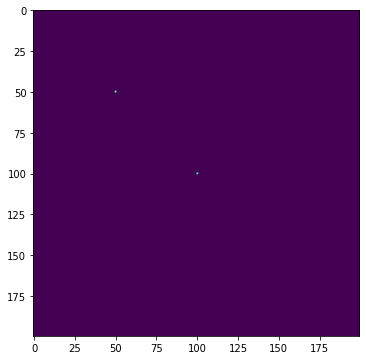

In [24]:
truth_type = 0

if truth_type == 0:
    n=200
    truth=np.zeros([n,n],dtype='float32')

    truth[n//4,n//4]=1000
    truth[n//2,n//2]=1000
if truth_type == 1:
    from skimage.io import imread
    im_path='D:/images/i2k2022/deconvolution/'
    truth_name='star.tif'

    truth=imread(im_path+truth_name)
    truth=truth.astype('float32')
    n=truth.shape[0]
    
fig=imshow2d(truth)


## Create the PSF

0.0 0.0060154707


C:\Users\bnort\AppData\Local\Temp\ipykernel_29776\1854977128.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
  psf = fftshift(ifftn(ifftshift(otf)).astype(np.float32))


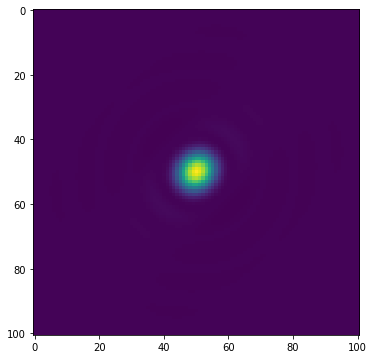

In [25]:
m=101
wavelength = 500
na=1.4
pixel_size = 20

psf=paraxial_psf(m, wavelength, na, pixel_size)
psf=psf-psf.min()
psf=psf/psf.sum()
print(psf.min(), psf.max())
fig=imshow2d(psf)

## Create the image

Note in this case we apply a window to the image, thus in the final image we only clearly see one emitter.

C:\Users\bnort\AppData\Local\Temp\ipykernel_29776\353309278.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  im = forward(truth, psf).astype('float32')


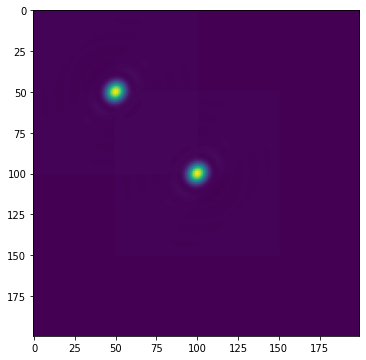

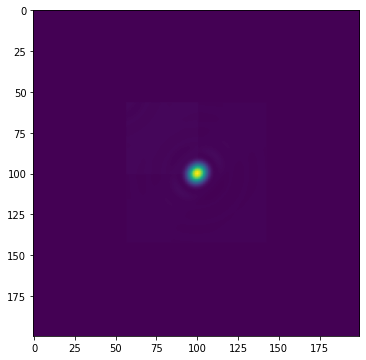

In [26]:
psf=pad(psf, truth.shape, 'constant')

ws=7

window=np.s_[n//4+ws:3*n//4-ws,n//4+ws:3*n//4-ws]
im = forward(truth, psf).astype('float32')
fig = imshow2d(im)
im=im[window]
im = pad(im, truth.shape, 'constant')
fig = imshow2d(im)

## Create the normalization factor

C:\Users\bnort\AppData\Local\Temp\ipykernel_29776\2216473432.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  normal=(ifftn(fftn(flat) * otf_)).astype(float)


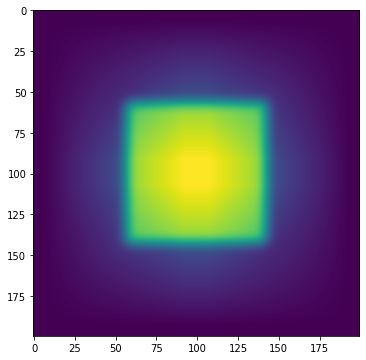

In [27]:
flat=np.ones_like(im)
flat=flat[window]
flat=pad(flat,truth.shape,'constant')

otf = fftn(fftshift(psf))
otf_ = np.conjugate(otf)    
normal=(ifftn(fftn(flat) * otf_)).astype(float)

delta=.00001
normal[normal<delta]=delta
fig = imshow2d(normal)


## Deconvolve

We call richardson lucy passing the normalization factor

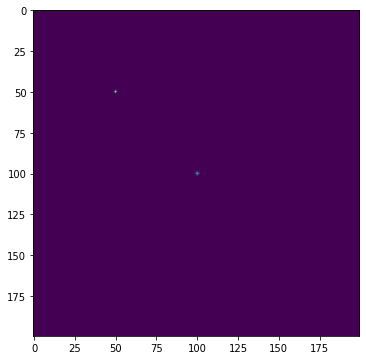

In [29]:
decon=richardson_lucy_np(im, psf, 1000, normal)
fig = imshow2d(decon)

## Inspect result in Napari

In [21]:
import napari
viewer = napari.Viewer()
viewer.add_image(decon)
viewer.add_image(im)



C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\jupyter_client\threaded.py", line 122, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\asyncio\base_events.py", line 623, in ru

<Image layer 'im' at 0x2074419a5b0>